# Predicting Wine Quality

We want to develop a predictive model that can accurately assess or predict the quality score of a wine based solely on its measurable physicochemical properties.

we will be using the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository since it is suitable for our goal


In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [143]:
red = pd.read_csv("winequality-red.csv",sep=';')
white = pd.read_csv("winequality-white.csv",sep=';')

## Dataset Features



The wine quality dataset contains the following physicochemical features:

- **fixed acidity**: The amount of non-volatile acids (tartaric, malic, citric) in wine, measured in g/dm³. These acids contribute to the wine's tartness and stability.

- **volatile acidity**: The amount of acetic acid in wine, measured in g/dm³. High levels can indicate wine spoilage and result in a vinegar-like taste.

- **citric acid**: The amount of citric acid present, measured in g/dm³. It adds freshness and flavor to wines, though typically found in small quantities.

- **residual sugar**: The amount of sugar remaining after fermentation stops, measured in g/dm³. Determines whether a wine is dry, off-dry, or sweet.

- **chlorides**: The amount of salt in the wine, measured in g/dm³. Contributes to the wine's taste and mouthfeel.

- **free sulfur dioxide**: The amount of free SO₂ in mg/dm³. Acts as an antimicrobial and antioxidant agent to prevent spoilage and oxidation.

- **total sulfur dioxide**: The total amount of SO₂ (free + bound forms) in mg/dm³. Includes both free and bound sulfur dioxide used as a preservative.

- **density**: The density of the wine, measured in g/cm³. Related to the sugar and alcohol content; typically ranges from 0.99 to 1.01 g/cm³.

- **pH**: The measure of acidity/alkalinity on a scale of 0-14. Most wines have a pH between 2.9 and 3.9. Lower pH indicates higher acidity.

- **sulphates**: The amount of potassium sulphate in g/dm³. Added as an antioxidant and antimicrobial agent, similar to sulfur dioxide.

- **alcohol**: The alcohol content of the wine, measured as % by volume. Typically ranges from 8-15% and contributes to body, sweetness, and flavor intensity.

- **quality**: The target variable representing wine quality, scored by expert tasters on a scale of 0-10 (though typically ranges from 3-9 in practice).

- **type**: The type of wine (red or white), added during data preprocessing to distinguish between the two wine categories.

Now we are going to check which of the categories in these dataframes affect the quality of the wine the most

In [144]:
print(white["alcohol"].sort_values(ascending=False))
print(white["quality"].unique())

3918    14.20
4503    14.05
3904    14.00
3150    14.00
1099    14.00
        ...  
3835     8.40
3839     8.40
4020     8.40
3265     8.00
2625     8.00
Name: alcohol, Length: 4898, dtype: float64
[6 5 7 8 4 3 9]


In [145]:
print(red["alcohol"].sort_values(ascending=False))
print(red["quality"].unique())

652     14.9
588     14.0
142     14.0
144     14.0
1270    14.0
        ... 
371      8.7
528      8.7
1436     8.5
544      8.4
517      8.4
Name: alcohol, Length: 1599, dtype: float64
[5 6 7 4 8 3]


In [146]:
# Calculate the correlation matrix and sort by the 'quality' column
quality_correlations_red = red.corr()['quality'].sort_values(ascending=False)
quality_correlations_white = white.corr()['quality'].sort_values(ascending=False)

# Print the results
print("Quality Correlations for Red Wine: \n", quality_correlations_red, "\n")
print("Quality Correlations for White Wine: \n", quality_correlations_white)

Quality Correlations for Red Wine: 
 quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64 

Quality Correlations for White Wine: 
 quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64


## Feature Selection

SelectKBest Red Wine

In [147]:
from sklearn.feature_selection import SelectKBest, f_regression

# Separate features and target
X_red = red.drop(columns=['quality'])
y_red = red['quality']

# Select top 5 features
selector_red = SelectKBest(score_func=f_regression, k=5)
selector_red.fit(X_red, y_red)

selectkbest_features_red = X_red.columns[selector_red.get_support()]
print("SelectKBest Selected Features (Red Wine):", list(selectkbest_features_red))


SelectKBest Selected Features (Red Wine): ['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']


SelectKBest chose volatile acidity, citric acid, total sulfur dioxide, sulphates, and alcohol because these features showed the strongest statistical relationship with wine quality, meaning they provide the most useful signal for predicting quality in the red wine dataset.

SelectKBest White Wine

In [148]:
X_white = white.drop(columns=['quality'])
y_white = white['quality']

selector_white = SelectKBest(score_func=f_regression, k=5)
selector_white.fit(X_white, y_white)

selectkbest_features_white = X_white.columns[selector_white.get_support()]
print("SelectKBest Selected Features (White Wine):", list(selectkbest_features_white))


SelectKBest Selected Features (White Wine): ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density', 'alcohol']


SelectKBest identified volatile acidity, chlorides, total sulfur dioxide, density, and alcohol as the top predictors because these features showed the strongest statistical relationship with white-wine quality, meaning they carry the most useful information for explaining changes in quality.

RFE for Red Wine

In [149]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

rfe_red = RFE(estimator=model, n_features_to_select=5)
rfe_red.fit(X_red, y_red)

rfe_features_red = X_red.columns[rfe_red.support_]
print("RFE Selected Features (Red Wine):", list(rfe_features_red))


RFE Selected Features (Red Wine): ['volatile acidity', 'chlorides', 'density', 'pH', 'sulphates']


RFE selected volatile acidity, chlorides, density, pH, and sulphates because the model found these features most helpful for predicting red-wine quality after repeatedly removing weaker variables, meaning these five contributed the strongest combined predictive power in the linear model.

RFE White Wine

In [174]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

rfe_white = RFE(estimator=model, n_features_to_select=5)
rfe_white.fit(X_white, y_white)

rfe_features_white = X_white.columns[rfe_white.support_]
print("RFE Selected Features (White Wine):", list(rfe_features_white))


RFE Selected Features (White Wine): ['volatile acidity', 'chlorides', 'density', 'sulphates', 'alcohol']


RFE selected volatile acidity, chlorides, density, sulphates, and alcohol because these features gave the linear model the strongest predictive power after removing weaker variables, meaning they work together well to explain white-wine quality.

## Correlation Analysis: What Do These Values Tell Us?



### Key Findings:

**1. Alcohol is the Strongest Predictor (Both Wine Types)**
   - **Red Wine**: 0.476 (moderate positive correlation)
   - **White Wine**: 0.436 (moderate positive correlation)
   - **Interpretation**: Higher alcohol content is associated with better quality in both wine types. This makes sense as alcohol contributes to body, complexity, and flavor intensity that experts value.

**2. Significant Differences Between Red and White Wines**
   - **Sulphates**: Strong positive for red (0.251) vs. weak for white (0.054)
   - **Citric Acid**: Positive for red (0.226) vs. slightly negative for white (-0.009)
   - **pH**: Negative for red (-0.058) vs. positive for white (0.099)
   - **Residual Sugar**: Near zero for red (0.014) vs. negative for white (-0.098)
   - **Interpretation**: Red and white wines have fundamentally different quality drivers, supporting the need to consider wine type in modeling.

**3. Strong Negative Correlations (Quality Detractors)**
   - **Red Wine**: Volatile acidity (-0.391) - strongest negative predictor
   - **White Wine**: Density (-0.307) - strongest negative predictor
   - **Interpretation**: High volatile acidity (vinegar taste) hurts red wine quality. High density (often from residual sugar) hurts white wine quality.

**4. Weak Correlations (Limited Predictive Power)**
   - Many features have correlations near zero (|r| < 0.1), including:
     - Residual sugar (red: 0.014, white: -0.098)
     - Free sulfur dioxide (red: -0.051, white: 0.008)
     - Citric acid (white: -0.009)
   - **Interpretation**: These features alone have minimal direct impact on quality, but may be important in combination with other features.

**5. Feature Importance Ranking**
   - **Red Wine Top 3**: Alcohol (0.476), Sulphates (0.251), Citric Acid (0.226)
   - **White Wine Top 3**: Alcohol (0.436), pH (0.099), Sulphates (0.054)
   - **Interpretation**: Alcohol dominates for both, but secondary features differ significantly.

### Implications for Modeling:
- **Alcohol** should be a key feature in any model
- **Wine type matters** - the relationships differ substantially between red and white
- **Feature selection** may benefit from type-specific approaches or interaction terms
- **Non-linear relationships** may exist since many correlations are weak - consider polynomial features or tree-based models

Now we are going to check for any missing values or outliers (using histogram and boxplot)

In [151]:
#Checking for missing values in both datasets
print("Missing values in Red Wine:")
print(red.isnull().sum(), "\n")
print("Missing values in White Wine:")
print(white.isnull().sum(), "\n")

Missing values in Red Wine:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 

Missing values in White Wine:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 



Fortunately there is no missing values for any of the categories

Now we are going to check for any outliers for the alcohol category

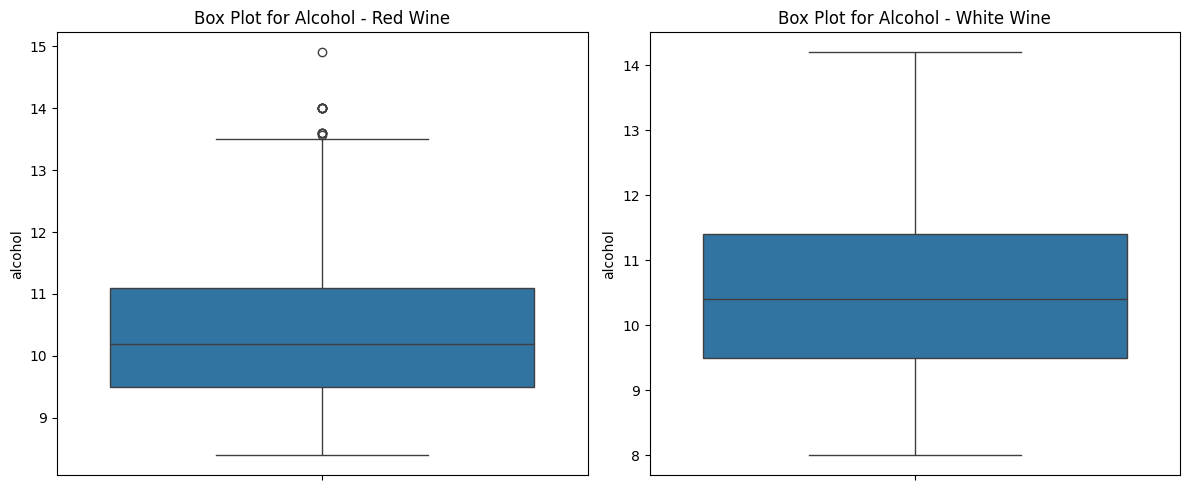

In [152]:
#Looking for outliers in alcohol for both wine types
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=red["alcohol"], ax=axes[0])
axes[0].set_title('Box Plot for Alcohol - Red Wine')
sns.boxplot(y=white["alcohol"], ax=axes[1])
axes[1].set_title('Box Plot for Alcohol - White Wine')
plt.tight_layout()
plt.show()

IQR Rule Red Wine

In [153]:
import pandas as pd

# Numeric columns for red wine
numeric_cols_red = red.select_dtypes(include=['float64', 'int64']).columns

outlier_summary_red = {}

for col in numeric_cols_red:
    Q1 = red[col].quantile(0.25)
    Q3 = red[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Outliers = values outside IQR bounds
    outliers = red[(red[col] < lower) | (red[col] > upper)]
    proportion = len(outliers) / len(red)

    outlier_summary_red[col] = round(proportion, 4)

# Convert to table
outliers_red_df = pd.DataFrame.from_dict(outlier_summary_red, orient='index', columns=['Outlier Proportion'])
print("Outlier Proportions - Red Wine")
outliers_red_df


Outlier Proportions - Red Wine


,Outlier Proportion
fixed acidity,0.0306
volatile acidity,0.0119
citric acid,0.0006
residual sugar,0.0969
chlorides,0.0700
free sulfur dioxide,0.0188
total sulfur dioxide,0.0344
density,0.0281
pH,0.0219
sulphates,0.0369


IQR Rule White Wine 

In [154]:
# Filter for wines where 'alcohol' is greater than 14 in both datasets
outliers_red = red[red['alcohol'] > 14]
outliers_white = white[white['alcohol'] > 14]

# Display the size of the outlier sets and samples
print(f"Red Wine - Number of wines with alcohol > 14: {outliers_red.shape[0]}")
if not outliers_red.empty:
    print("Sample of red wines with high alcohol content:")
    print(outliers_red[['alcohol', 'quality']].head())
    print(f"Unique quality scores: {sorted(outliers_red['quality'].unique())}")

print(f"\nWhite Wine - Number of wines with alcohol > 14: {outliers_white.shape[0]}")
if not outliers_white.empty:
    print("Sample of white wines with high alcohol content:")
    print(outliers_white[['alcohol', 'quality']].head())
    print(f"Unique quality scores: {sorted(outliers_white['quality'].unique())}")

Red Wine - Number of wines with alcohol > 14: 1
Sample of red wines with high alcohol content:
     alcohol  quality
652     14.9        5
Unique quality scores: [np.int64(5)]

White Wine - Number of wines with alcohol > 14: 2
Sample of white wines with high alcohol content:
      alcohol  quality
3918    14.20        7
4503    14.05        7
Unique quality scores: [np.int64(7)]


Now we are going to check if there is a relation between alcohol and wine quality by using a scatter plot

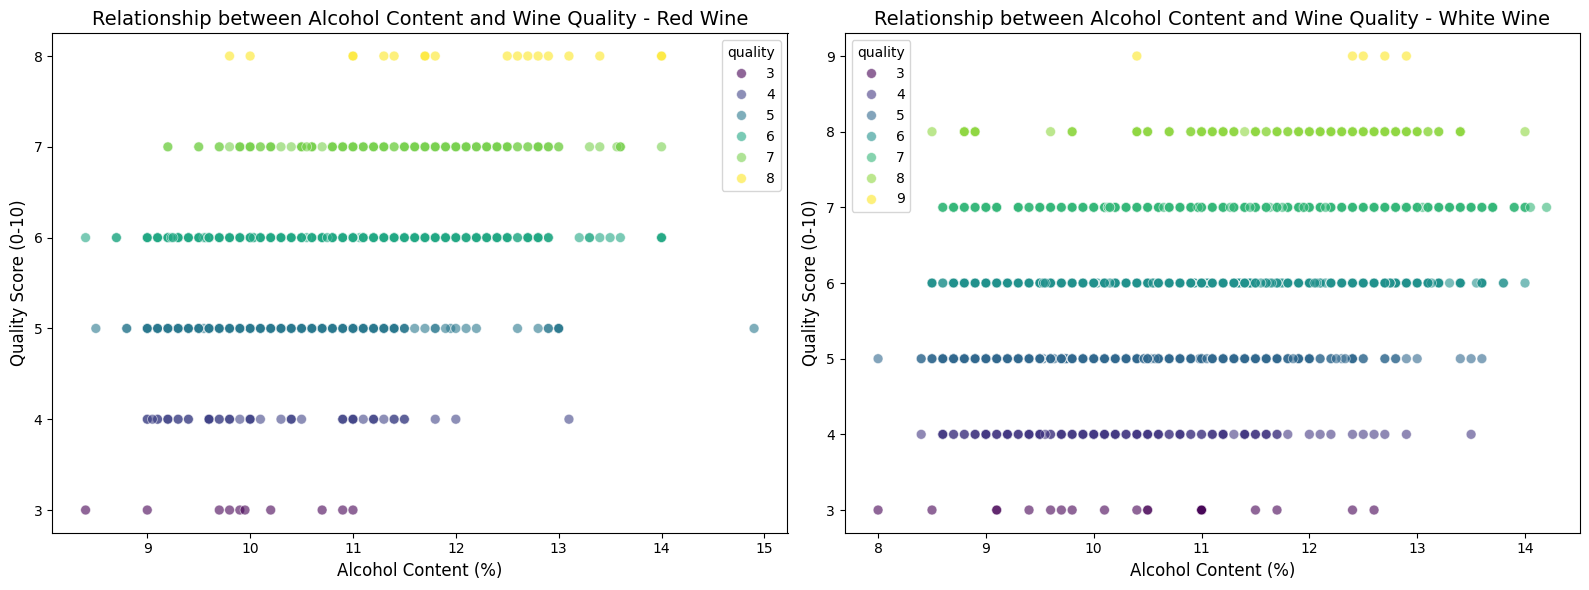

In [155]:
# Create scatter plots for both wine types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Red wine scatter plot
sns.scatterplot(x='alcohol', y='quality', data=red, alpha=0.6, s=50,
                hue='quality', palette='viridis', ax=axes[0])
axes[0].set_title('Relationship between Alcohol Content and Wine Quality - Red Wine', fontsize=14)
axes[0].set_xlabel('Alcohol Content (%)', fontsize=12)
axes[0].set_ylabel('Quality Score (0-10)', fontsize=12)
axes[0].set_yticks(sorted(red['quality'].unique()))

# White wine scatter plot
sns.scatterplot(x='alcohol', y='quality', data=white, alpha=0.6, s=50,
                hue='quality', palette='viridis', ax=axes[1])
axes[1].set_title('Relationship between Alcohol Content and Wine Quality - White Wine', fontsize=14)
axes[1].set_xlabel('Alcohol Content (%)', fontsize=12)
axes[1].set_ylabel('Quality Score (0-10)', fontsize=12)
axes[1].set_yticks(sorted(white['quality'].unique()))

plt.tight_layout()
plt.savefig('alcohol_vs_quality_scatter.png')
plt.show()

Now we are going to check if there is a relation between volatile acidity and wine quality by using a scatter plot

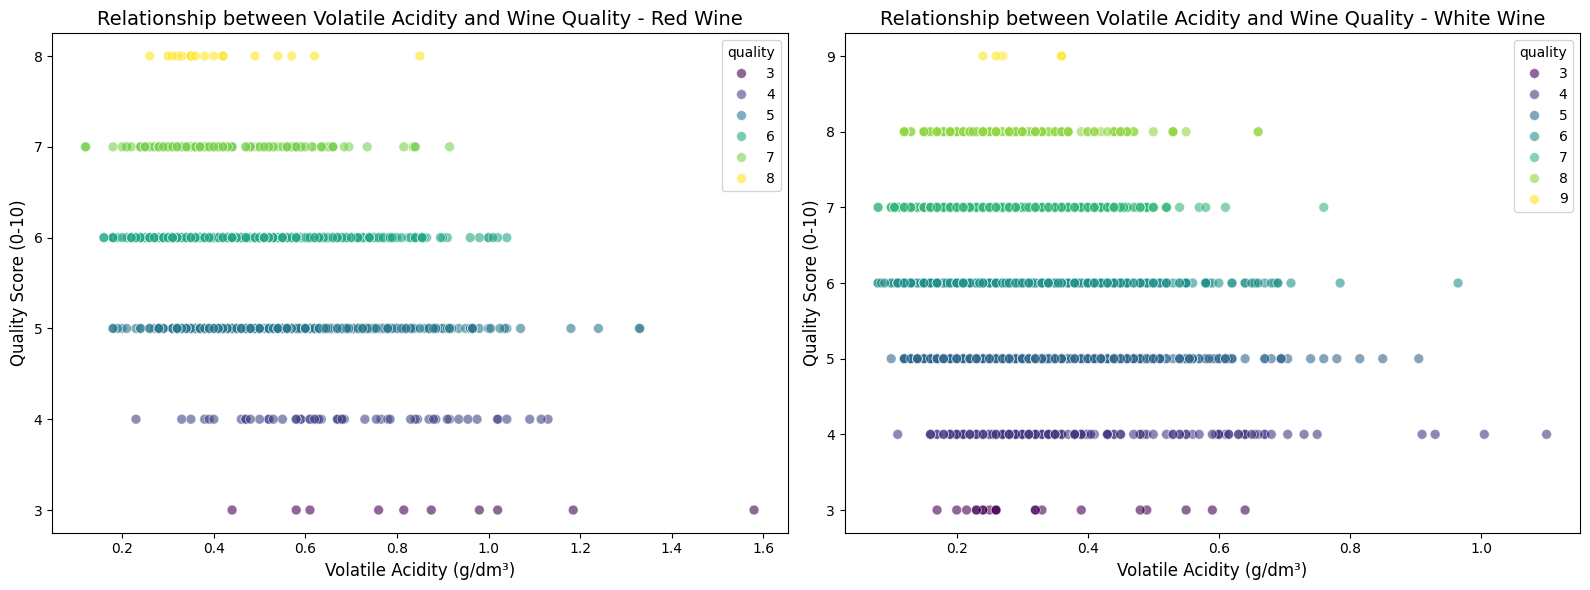

In [156]:
# Create scatter plots for volatile acidity vs quality for both wine types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Red wine scatter plot
sns.scatterplot(x='volatile acidity', y='quality', data=red, alpha=0.6, s=50,
                hue='quality', palette='viridis', ax=axes[0])
axes[0].set_title('Relationship between Volatile Acidity and Wine Quality - Red Wine', fontsize=14)
axes[0].set_xlabel('Volatile Acidity (g/dm³)', fontsize=12)
axes[0].set_ylabel('Quality Score (0-10)', fontsize=12)
axes[0].set_yticks(sorted(red['quality'].unique()))

# White wine scatter plot
sns.scatterplot(x='volatile acidity', y='quality', data=white, alpha=0.6, s=50,
                hue='quality', palette='viridis', ax=axes[1])
axes[1].set_title('Relationship between Volatile Acidity and Wine Quality - White Wine', fontsize=14)
axes[1].set_xlabel('Volatile Acidity (g/dm³)', fontsize=12)
axes[1].set_ylabel('Quality Score (0-10)', fontsize=12)
axes[1].set_yticks(sorted(white['quality'].unique()))

plt.tight_layout()
plt.savefig('volatile_acidity_vs_quality_scatter.png')
plt.show()

Now we are going to check if there is a relation between Density Content and wine quality by using a scatter plot

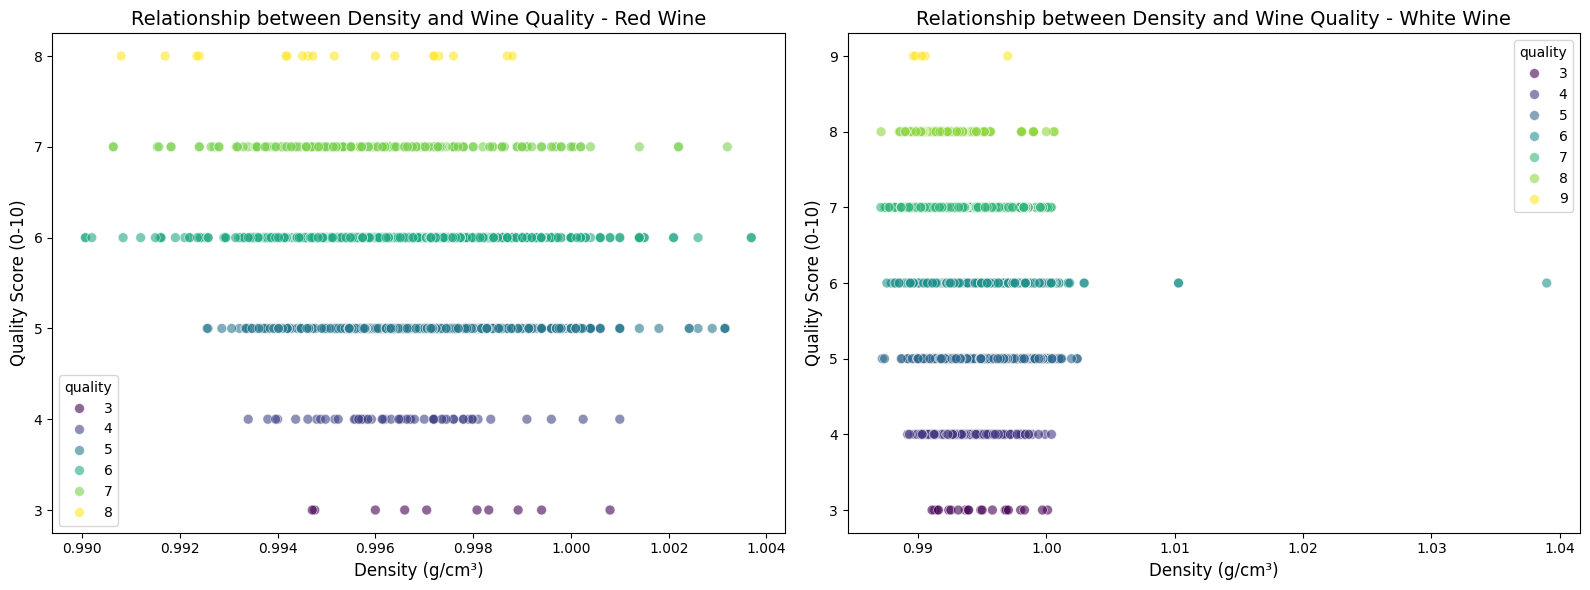

In [157]:
# Create scatter plots for density vs quality for both wine types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Red wine scatter plot
sns.scatterplot(x='density', y='quality', data=red, alpha=0.6, s=50,
                hue='quality', palette='viridis', ax=axes[0])
axes[0].set_title('Relationship between Density and Wine Quality - Red Wine', fontsize=14)
axes[0].set_xlabel('Density (g/cm³)', fontsize=12)
axes[0].set_ylabel('Quality Score (0-10)', fontsize=12)
axes[0].set_yticks(sorted(red['quality'].unique()))

# White wine scatter plot
sns.scatterplot(x='density', y='quality', data=white, alpha=0.6, s=50,
                hue='quality', palette='viridis', ax=axes[1])
axes[1].set_title('Relationship between Density and Wine Quality - White Wine', fontsize=14)
axes[1].set_xlabel('Density (g/cm³)', fontsize=12)
axes[1].set_ylabel('Quality Score (0-10)', fontsize=12)
axes[1].set_yticks(sorted(white['quality'].unique()))

plt.tight_layout()
plt.savefig('density_vs_quality_scatter.png')
plt.show()

Wine Quality Counts

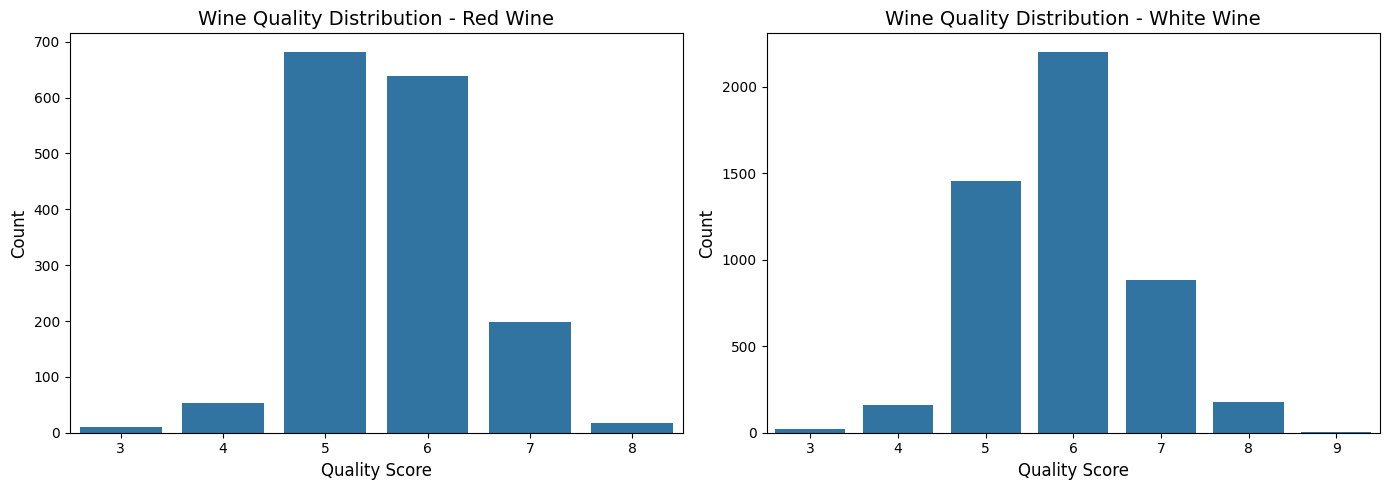

In [158]:
# Quality distribution for both wine types
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x="quality", data=red, ax=axes[0])
axes[0].set_title("Wine Quality Distribution - Red Wine", fontsize=14)
axes[0].set_xlabel("Quality Score", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)

sns.countplot(x="quality", data=white, ax=axes[1])
axes[1].set_title("Wine Quality Distribution - White Wine", fontsize=14)
axes[1].set_xlabel("Quality Score", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()

## Data Split

before training any models we will split the data into 70% for training and the remaining 30% will be used for testing

In [159]:
#feature and target for Red Whine
X_red = red.drop(columns=['quality'])
y_red = red['quality']

#Data split
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y_red, test_size=0.30, random_state=42
)

In [160]:
#feature and target for White Whine
X_white = white.drop(columns=['quality'])
y_white = white['quality']

#Data split
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(
    X_white, y_white, test_size=0.30, random_state=42
)

We will use some different models and see which one performs the best for this dataset

## Linear Regression

Linear Regression for Red Wine

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
lr = LinearRegression()

# Train it
lr.fit(X_red_train, y_red_train)

# Predict
y_pred_lr = lr.predict(X_red_test)

# Evaluate
mse_lr = mean_squared_error(y_red_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5
r2_lr = r2_score(y_red_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)


Linear Regression RMSE: 0.641275971599139
Linear Regression R²: 0.351388533250524


Our models predicts wine quality with an average error of about 0.64 points and explains roughly 35% of the variation in quality 

Linear Regression for White Wine

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
lr = LinearRegression()

# Train it
lr.fit(X_white_train, y_white_train)

# Predict
y_pred_lr = lr.predict(X_white_test)

# Evaluate
mse_lr = mean_squared_error(y_white_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5
r2_lr = r2_score(y_white_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)


Linear Regression RMSE: 0.7445083834408281
Linear Regression R²: 0.26586871324780914


Our models predicts wine quality with an average error of about 0.74 points and explains roughly 27% of the variation in quality 

## K-Nearest Neighbors

we are going to first use K-Nearest Neighbors (KNN) Model

KNN on Red Wine:

In [163]:
#Training Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# KNN model wrapped in a Pipeline (so scaling happens automatically)
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=11))
])

knn.fit(X_red_train, y_red_train)

#Evaluating model
from sklearn.metrics import mean_squared_error, r2_score

y_red_pred_knn = knn.predict(X_red_test)

mse_knn = mean_squared_error(y_red_test, y_red_pred_knn)
rmse_knn = mse_knn ** 0.5

r2_knn = r2_score(y_red_test, y_red_pred_knn)

print("KNN RMSE:", rmse_knn)
print("KNN R^2", r2_knn)

KNN RMSE: 0.6617371120842792
KNN R^2 0.3093378263171196


Our model for red wine predicts quality with an average error of 0.66 points and explains about 31% of the variation, which is typical for a similarity-based model on this dataset (since wine quality is noisy and hard to predict so KNN usually struggles and can only capture a small portion of the true patterns in the chemical data)

In [164]:
#finding the best k value 
results = []

for k in range(1, 21):   # test k from 1 to 20
    knn_test = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=k))
    ])
    
    knn_test.fit(X_red_train, y_red_train)
    pred = knn_test.predict(X_red_test)
    
    mse = mean_squared_error(y_red_test, pred)
    rmse = mse ** 0.5
    
    # store (k, rmse)
    results.append((k, rmse))

# sort results by rmse descending
results_sorted = sorted(results, key=lambda x: x[1], reverse=False)

# print results
for k, rmse in results_sorted:
    print(f"k={k}, RMSE={rmse}")



k=11, RMSE=0.6617371120842792
k=12, RMSE=0.6628362179693048
k=13, RMSE=0.6628713465603486
k=18, RMSE=0.6643381402637165
k=19, RMSE=0.6645496743069114
k=20, RMSE=0.6646819414827917
k=16, RMSE=0.6651247631240573
k=10, RMSE=0.6653789647010692
k=17, RMSE=0.6656584793065168
k=14, RMSE=0.6659461455008828
k=7, RMSE=0.6660818012724823
k=9, RMSE=0.6662228460946353
k=15, RMSE=0.6666944438657648
k=8, RMSE=0.6702378309227255
k=5, RMSE=0.6729908369856655
k=6, RMSE=0.6750342926817098
k=4, RMSE=0.6780601927557759
k=3, RMSE=0.6853290639728669
k=2, RMSE=0.7107800878846658
k=1, RMSE=0.758287544405155


KNN on White Wine:

In [165]:
#Training Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# KNN model wrapped in a Pipeline (so scaling happens automatically)
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=5))
])

knn.fit(X_white_train, y_white_train)

#Evaluating model
from sklearn.metrics import mean_squared_error, r2_score

y_white_pred_knn = knn.predict(X_white_test)

mse_knn = mean_squared_error(y_white_test, y_white_pred_knn)
rmse_knn = mse_knn ** 0.5

r2_knn = r2_score(y_white_test, y_white_pred_knn)

print("KNN RMSE:", rmse_knn)
print("KNN R^2", r2_knn)

KNN RMSE: 0.6931344560398508
KNN R^2 0.36368886254718713


For White Wine our model predicts quality with an average error of 0.69 points and explains about 36% of teh variation, which is normal for KNN (already explained with the red wine scores)

In [166]:
#finding the best k value 
results = []

for k in range(1, 21):   # test k from 1 to 20
    knn_test = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=k))
    ])
    
    knn_test.fit(X_white_train, y_white_train)
    pred = knn_test.predict(X_white_test)
    
    mse = mean_squared_error(y_white_test, pred)
    rmse = mse ** 0.5
    
    # store (k, rmse)
    results.append((k, rmse))

# sort results by rmse descending
results_sorted = sorted(results, key=lambda x: x[1], reverse=False)

# print results
for k, rmse in results_sorted:
    print(f"k={k}, RMSE={rmse}")



k=5, RMSE=0.6931344560398508
k=6, RMSE=0.694242601052144
k=7, RMSE=0.6953565669790369
k=8, RMSE=0.6955886265710258
k=9, RMSE=0.6991458393482154
k=4, RMSE=0.7014319658534878
k=15, RMSE=0.7041653416778314
k=14, RMSE=0.7050446928252292
k=17, RMSE=0.7051934079573222
k=18, RMSE=0.7052812805705763
k=12, RMSE=0.7055618047467282
k=16, RMSE=0.705720596535307
k=10, RMSE=0.7058164568415073
k=13, RMSE=0.7058960663801823
k=11, RMSE=0.7061002852735064
k=19, RMSE=0.7068868879140582
k=20, RMSE=0.7070779190962404
k=3, RMSE=0.7121130979331313
k=2, RMSE=0.733897433008776
k=1, RMSE=0.7941109776964169


## Random Forest

we will now use a random forest with all the features since random forest works better with more features and will ignore features that don't have much correlation with our target

Random Forest for Red Whine:

In [167]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_red_train, y_red_train)

#evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_red_pred = rf.predict(X_red_test)

mse = mean_squared_error(y_red_test, y_red_pred)
rmse = mse ** 0.5

r2 = r2_score(y_red_test, y_red_pred)

print("Random Forest RMSE:", rmse)
print("Random Forest R²:", r2)

Random Forest RMSE: 0.5894697672327915
Random Forest R²: 0.45195305736393776


Root Mean Squared Error tells us how far a prediction is from the true wine quality on average

Since our quality scores range from 0 to 10, but almost all wines in this dataset fall between 3 and 8.

So an RMSE of 0.589 means that our predictions are off by about half a point on the 0-10 quality scale.

This is normal and expected for this dataset since wine quality is noisy and hard to predict perfectly.

R $^2$ measures how much of the variation in quality the model explains.

Our value is 0.452 so the model explains about 45% of the differences in wine quality.

The other 55% could come from factors not in the dataset (e.g. taste preferences, human judgment, missing chemicals factors, etc.)

For this particular dataset, an R $^2$ around 0.40-0.55 is typical since random forest models usually land in this range unless extremely tuned.

So our model is performing normally for the red wine dataset.




Tunning Random Forest for Red Wine

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid to try
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_red_train, y_red_train)

print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_red_test)

mse_best = mean_squared_error(y_red_test, y_pred_best)
rmse_best = mse_best ** 0.5
r2_best = r2_score(y_red_test, y_pred_best)

print("Tuned Random Forest RMSE:", rmse_best)
print("Tuned Random Forest R²:", r2_best)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest RMSE: 0.5894697672327915
Tuned Random Forest R²: 0.45195305736393776


The tuned Random Forest produced the exact same RMSE (0.5895) and R² (0.4520) as before, which means the original model was already using the best parameters and no further improvements were possible through tuning.

Random Forest for White Wine

In [169]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_white_train, y_white_train)

#evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_white_pred = rf.predict(X_white_test)

mse = mean_squared_error(y_white_test, y_white_pred)
rmse = mse ** 0.5

r2 = r2_score(y_white_test, y_white_pred)

print("Random Forest RMSE:", rmse)
print("Random Forest R²:", r2)

Random Forest RMSE: 0.5966229731021575
Random Forest R²: 0.52855124629008


For an RMSE of 0.596 our prediction is off by about 0.60 points on the 0-10 wine quality scale.

Similar to red wine, this is normal because wine quality is noisy and subjective.

For an R $^2$ of 0.529 our model explains about 53% of what determines white wine quality.

This is actually better than our red wine model (which explain about 45%)

It seems like white wine performs better than red wine (because its chemical measurements are more consistent)

So a value of 0.528 is normal

Tunning Random Forest for White Wine

In [170]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid for tuning
param_grid_white = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_white_model = RandomForestRegressor(random_state=42)

grid_search_white = GridSearchCV(
    estimator=rf_white_model,
    param_grid=param_grid_white,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search_white.fit(X_white_train, y_white_train)

print("Best Parameters (White Wine):", grid_search_white.best_params_)

# Evaluate tuned model
best_rf_white = grid_search_white.best_estimator_
y_white_pred_best = best_rf_white.predict(X_white_test)

mse_white_best = mean_squared_error(y_white_test, y_white_pred_best)
rmse_white_best = mse_white_best ** 0.5
r2_white_best = r2_score(y_white_test, y_white_pred_best)

print("Tuned Random Forest RMSE (White):", rmse_white_best)
print("Tuned Random Forest R² (White):", r2_white_best)


Best Parameters (White Wine): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest RMSE (White): 0.5966229731021575
Tuned Random Forest R² (White): 0.52855124629008


The tuned Random Forest produced the exact same RMSE (0.5966) and R² (0.5285) as before, which means the original model was already using the best parameters and no further improvements were possible through tuning.

## Gradient Boosting

Decision Tree for Red Wine

In [171]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
gbr = GradientBoostingRegressor(
    n_estimators=300,     # number of boosting stages
    learning_rate=0.05,  # step size shrinkage
    max_depth=3,         # depth of each tree
    random_state=42
)

# Train
gbr.fit(X_red_train, y_red_train)

# Predict
y_pred_gbr = gbr.predict(X_red_test)

# Evaluate
mse_gbr = mean_squared_error(y_red_test, y_pred_gbr)
rmse_gbr = mse_gbr ** 0.5
r2_gbr = r2_score(y_red_test, y_pred_gbr)

print("Gradient Boosting RMSE:", rmse_gbr)
print("Gradient Boosting R²:", r2_gbr)


Gradient Boosting RMSE: 0.6226069656844117
Gradient Boosting R²: 0.38860393671369575


our Gradient Boosting model predicts wine quality with an average error of about 0.62 points, and it explains around 39% of the variation, meaning that it captures some useful patterns but is still less accurate than the Random Forest.

In [172]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
gbr = GradientBoostingRegressor(
    n_estimators=300,     # number of boosting stages
    learning_rate=0.05,  # step size shrinkage
    max_depth=3,         # depth of each tree
    random_state=42
)

# Train
gbr.fit(X_white_train, y_white_train)

# Predict
y_pred_gbr = gbr.predict(X_white_test)

# Evaluate
mse_gbr = mean_squared_error(y_white_test, y_pred_gbr)
rmse_gbr = mse_gbr ** 0.5
r2_gbr = r2_score(y_white_test, y_pred_gbr)

print("Gradient Boosting RMSE:", rmse_gbr)
print("Gradient Boosting R²:", r2_gbr)


Gradient Boosting RMSE: 0.6679387429715835
Gradient Boosting R²: 0.40910839762039797


For white wine the model is off by about 0.67 quality points on average, and it explains around 41% of the differences in wine quality, which also shows some useful patterns but still limited.